# Information Content based Triplet Periodicity Metric Investigation

Investigation of using information content of read frame distributions to measure triplet periodicity. 

## Import Functions

In [1]:
from RiboMetric.modules import (
    read_frame_distribution,
    a_site_calculation,
)
import matplotlib.pyplot as plt
import pandas as pd
import math
import numpy as np

In [2]:
def calculate_score(probabilities):
    '''
    Calculate the triplet periocity score for a given probability of a read being in frame.
    The score is the square root of the bits of information in the triplet distribution.

    Numerator is the Maximum Entropy of the triplet distribution minus the entropy of the triplet distribution.
    Denominator is the Maximum Entropy of the triplet distribution.

    Inputs:
        probability (float): The probability of a read being in frame.

    Returns:
        result (float): The triplet periodicity score.
    '''
    result = 0
    for probability in probabilities:
        numerator = math.log2(3) + (probability * math.log2(probability)) + \
            ((1 - probability) * math.log2((1 - probability) / 2))
        denominator = math.log2(3)
        result = max(result, numerator / denominator)
    return result

In [3]:
# def calculate_score(probabilities):
#     '''
#     Calculate the triplet periocity score for a given probability of a read being in frame.
#     The score is the square root of the bits of information in the triplet distribution.

#     Numerator is the Maximum Entropy of the triplet distribution minus the entropy of the triplet distribution.
#     Denominator is the Maximum Entropy of the triplet distribution.

#     Inputs:
#         probability (float): The probability of a read being in frame.

#     Returns:
#         result (float): The triplet periodicity score.
#     '''
#     maximum_entropy = math.log2(3)
#     entropy = 0
#     for probability in probabilities:
#         entropy += -(probability * math.log2(probability))

#     result = math.sqrt((maximum_entropy - entropy) / maximum_entropy)
#     return result



In [4]:
def read_frame_distribution_metric(
    read_frame_distribution: dict,
        ) -> float:
    """       
    Calculate the read frame distribution metric from the output of
    the read_frame_distribution module.

    This metric is the Shannon entropy of the read frame distribution 

    Inputs:
        read_frame_distribution: Dictionary containing the output of the
                read_frame_distribution module
        
    Outputs:
        read_frame_distribution_metric: Shannon entropy of the read frame
                distribution
    """

    pseudocount = 1e-10000
    scores = {}
    for read_length in read_frame_distribution:
        total_count = sum(read_frame_distribution[read_length].values())

        probabilities = []
        for frame, count in read_frame_distribution[read_length].items():
            prob = (count + pseudocount) / total_count
            probabilities.append(prob)

        score = calculate_score(probabilities)

        scores[read_length] = (score, total_count, probabilities)
    return scores

# Explore Score Relative to Probability

Set up a simulate case where each read length has a different proportion of reads in each frame (n = 100). These permutations mean that the full range of probabilities that reads come from a given frame are represented

In [5]:
import itertools

numbers = range(1, 101)

permutations = []
for perm in itertools.permutations(numbers, 3):
    if sum(perm) == 100:
        permutations.append(perm)

read_frame_continuous = {}
for i, perm in enumerate(permutations):
    read_frame_continuous[i] = {0: perm[0], 1: perm[1], 2: perm[2]}

In [6]:
read_frame_metric_cont_extended = read_frame_distribution_metric(read_frame_continuous)

In [7]:
cont_extended = [
    (read_frame_metric_cont_extended[i][0],
     math.sqrt(read_frame_metric_cont_extended[i][0]),
     read_frame_metric_cont_extended[i][2][0],
     read_frame_metric_cont_extended[i][2][1],
     read_frame_metric_cont_extended[i][2][2]) for i in read_frame_metric_cont_extended
     ]
df = pd.DataFrame(cont_extended, columns=["score", "sqrt", "prob1", "prob2", "prob3"])
df.describe()

,score,sqrt,prob1,prob2,prob3
count,4704.000000,4704.000000,4704.000000,4704.000000,4704.000000
mean,0.213148,0.426135,0.333333,0.333333,0.333333
std,0.160814,0.177661,0.232164,0.232164,0.232164
min,0.000564,0.023756,0.010000,0.010000,0.010000
25%,0.088787,0.297971,0.140000,0.140000,0.140000
50%,0.182363,0.427040,0.290000,0.290000,0.290000
75%,0.292450,0.540786,0.500000,0.500000,0.500000
max,0.858425,0.926512,0.970000,0.970000,0.970000


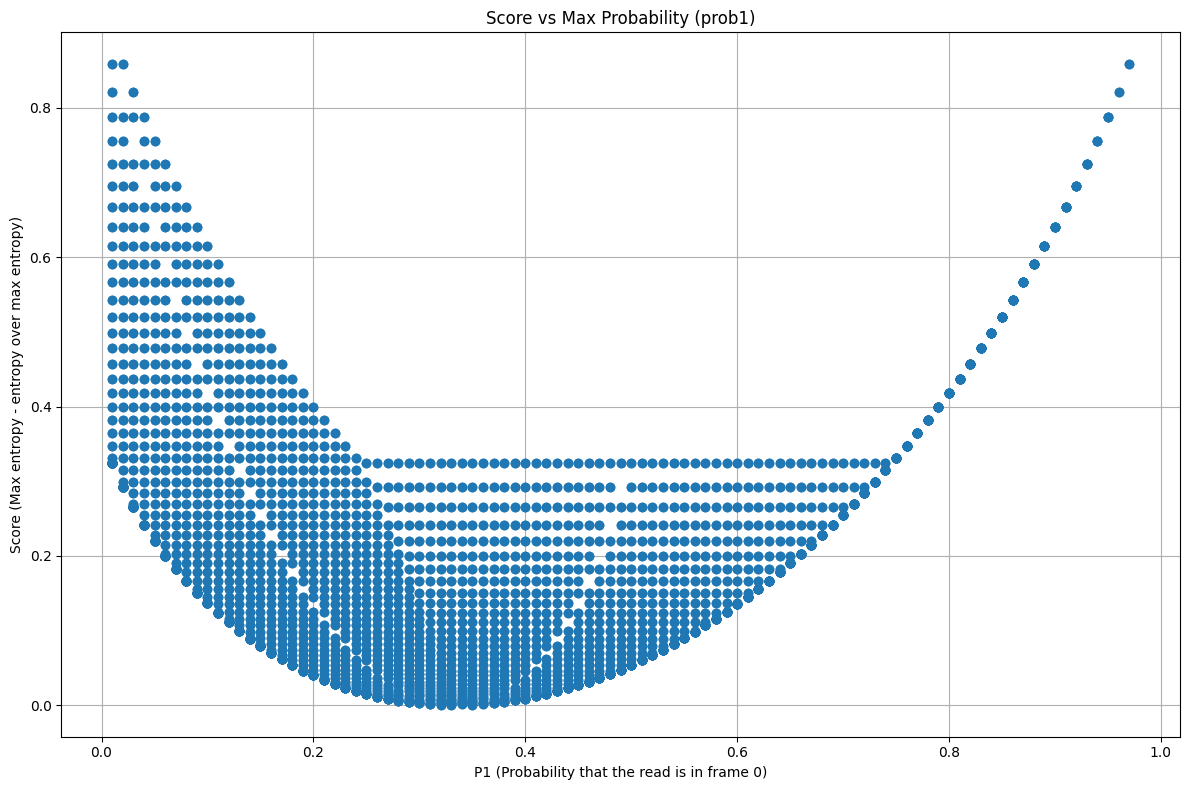

In [8]:
fig, axes = plt.subplots(1, 1, figsize=(12, 8))

axes.plot(df["prob1"], df["score"], 'o')
axes.set_xlabel('P1 (Probability that the read is in frame 0)')
axes.set_ylabel('Score (Max entropy - entropy over max entropy)')
axes.set_title('Score vs Max Probability (prob1)')
axes.grid(True)

plt.tight_layout()
plt.show()


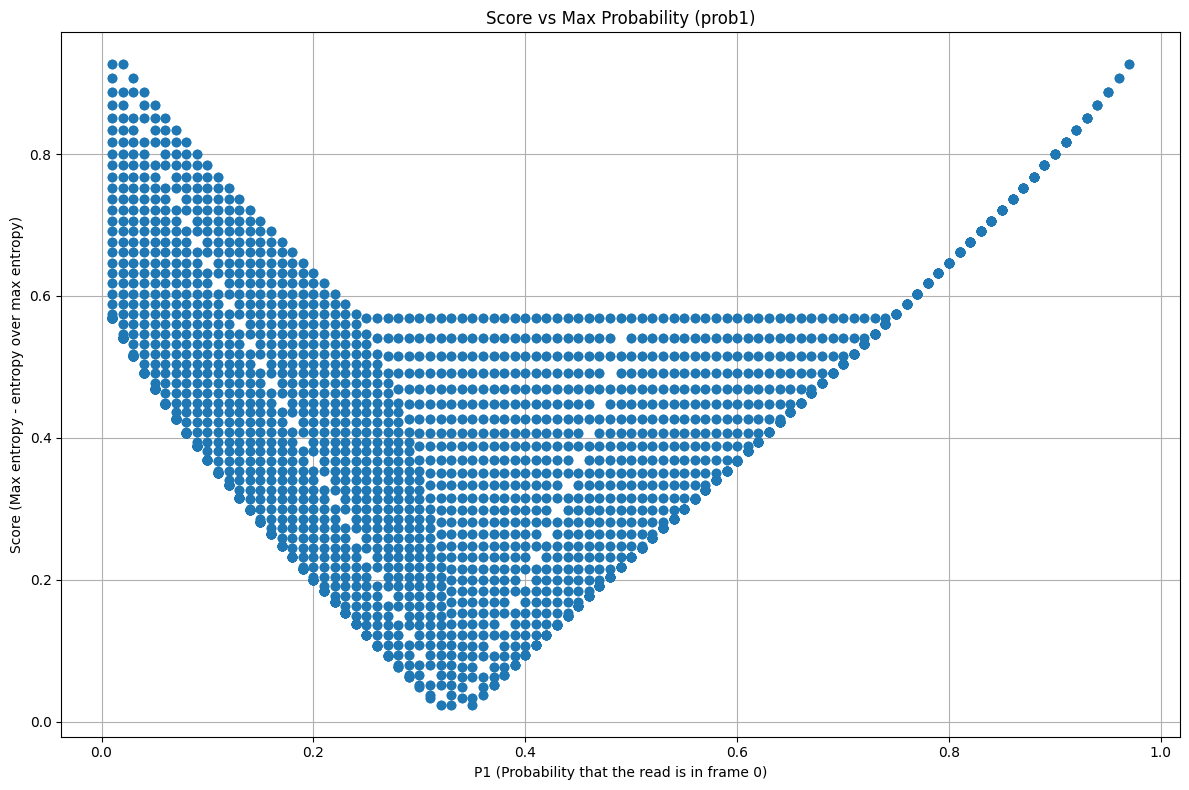

In [9]:
fig, axes = plt.subplots(1, 1, figsize=(12, 8))

axes.plot(df["prob1"], df["sqrt"], 'o')
axes.set_xlabel('P1 (Probability that the read is in frame 0)')
axes.set_ylabel('Score (Max entropy - entropy over max entropy)')
axes.set_title('Score vs Max Probability (prob1)')
axes.grid(True)

plt.tight_layout()
plt.show()

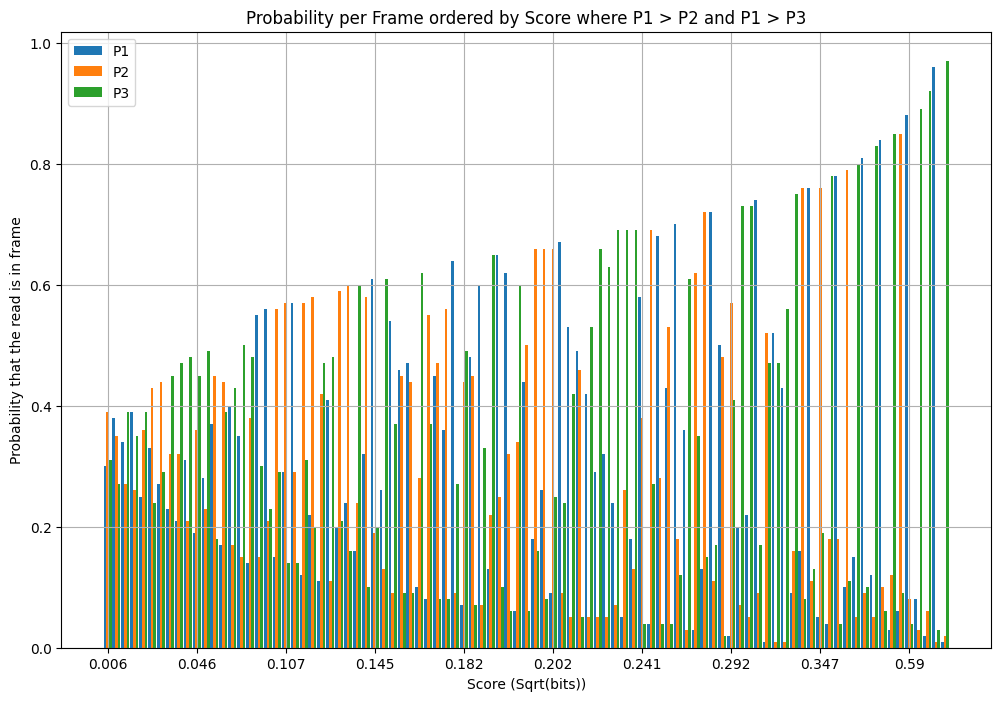

In [10]:
df_subset = df.iloc[::50, :]
df_subset = df_subset.sort_values('score')

num_rows = len(df_subset)
group_width = 0.3
bar_positions = np.arange(num_rows)

plt.figure(figsize=(12, 8))
plt.bar(bar_positions, df_subset['prob1'], width=group_width, align='center', label='P1')
plt.bar(bar_positions + group_width, df_subset['prob2'], width=group_width, align='center', label='P2')
plt.bar(bar_positions + 2 * group_width, df_subset['prob3'], width=group_width, align='center', label='P3')

plt.xlabel('Score (Sqrt(bits))')
plt.ylabel('Probability that the read is in frame')
plt.title('Probability per Frame ordered by Score where P1 > P2 and P1 > P3')

x_ticks = bar_positions[::10]
plt.xticks(x_ticks + group_width, round(df_subset['score'].iloc[x_ticks], 3))

plt.legend()
plt.grid(True)
plt.show()


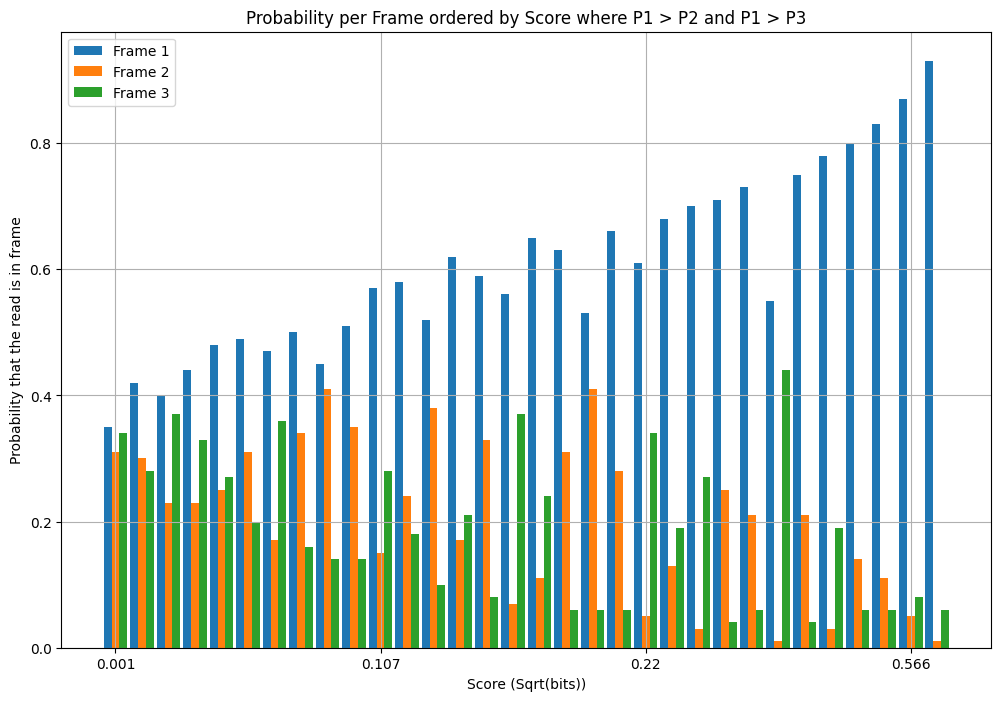

In [11]:
df_p1_subset = df[(df['prob1'] > df['prob2']) & (df['prob1'] > df['prob3'])]

df_p1_subset = df_p1_subset.iloc[::50, :]

df_p1_subset = df_p1_subset.sort_values('score')

num_rows = len(df_p1_subset)
group_width = 0.3
bar_positions = np.arange(num_rows)

plt.figure(figsize=(12, 8))
plt.bar(bar_positions, df_p1_subset['prob1'], width=group_width, align='center', label='Frame 1')
plt.bar(bar_positions + group_width, df_p1_subset['prob2'], width=group_width, align='center', label='Frame 2')
plt.bar(bar_positions + 2 * group_width, df_p1_subset['prob3'], width=group_width, align='center', label='Frame 3')

plt.xlabel('Score (Sqrt(bits))')
plt.ylabel('Probability that the read is in frame')
plt.title('Probability per Frame ordered by Score where P1 > P2 and P1 > P3')

x_ticks = bar_positions[::10]
plt.xticks(x_ticks + group_width, round(df_p1_subset['score'].iloc[x_ticks], 3))

plt.legend()
plt.grid(True)
plt.show()

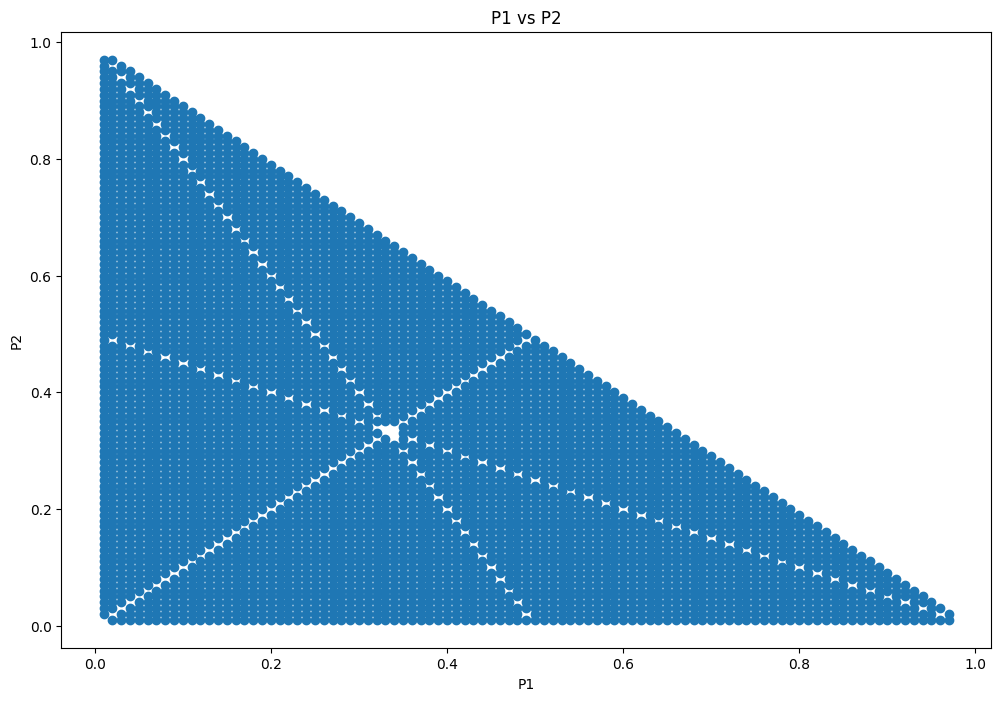

In [12]:
# scatter plot of prob1 vs prob2
plt.figure(figsize=(12, 8))
plt.scatter(df['prob1'], df['prob2'])
plt.xlabel('P1')
plt.ylabel('P2')
plt.title('P1 vs P2')
plt.show()

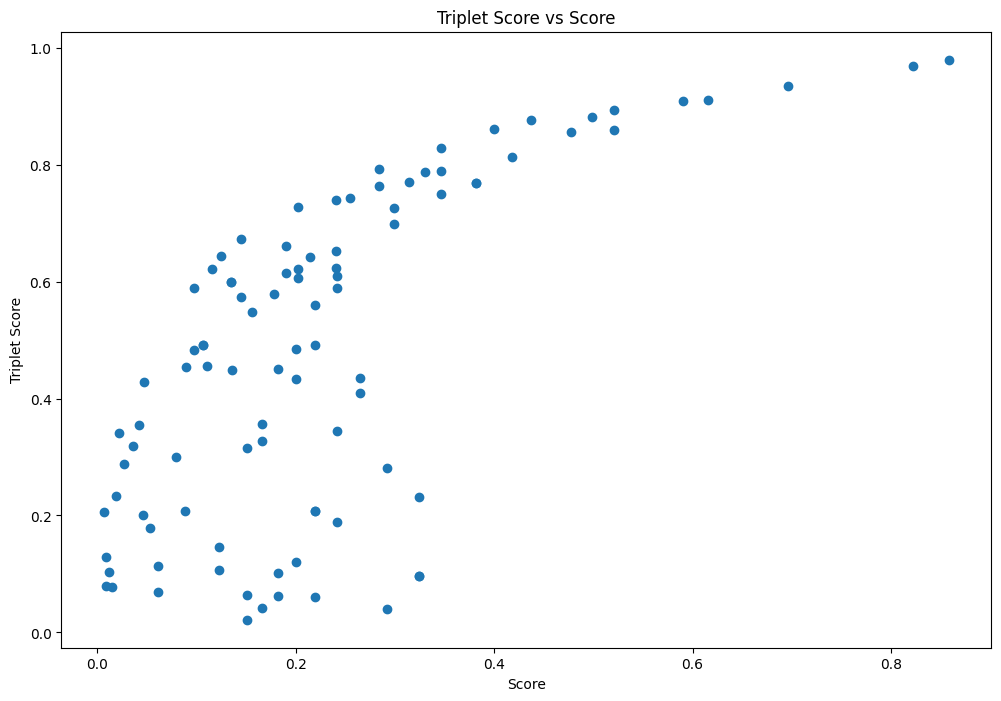

In [25]:
df_subset['Trips_Score'] = df_subset.apply(lambda x: 1 - (sorted([x['prob1'], x['prob2'], x['prob3']], reverse=True)[1] / sorted([x['prob1'], x['prob2'], x['prob3']], reverse=True)[0]), axis=1)
plt.figure(figsize=(12, 8))
plt.scatter(df_subset['score'], df_subset['Trips_Score'])
plt.xlabel('Score')
plt.ylabel('Triplet Score')
plt.title('Triplet Score vs Score')
plt.show()

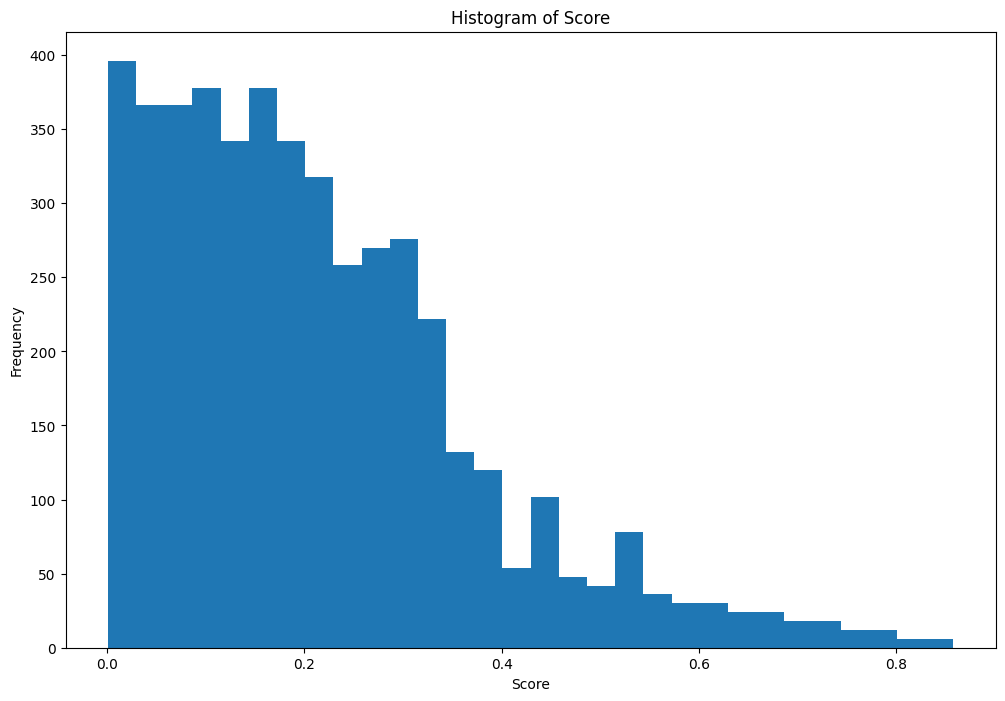

In [26]:
# histogram of score
plt.figure(figsize=(12, 8))
plt.hist(df['score'], bins=30)
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.title('Histogram of Score')
plt.show()